# Project : 25-26: 4369 -- PROGRAMMING FOR DATA ANALYTICS


__Author    : Clyde Watts__  
__Lecturere : Andrew Beaty__  
__Date      : 2025-11-20__






## Introduction ##

This project will examine the data from a residintial solor system , and do some analysis.

The following data sets will be used

| Data Source | Description | File Type |
|:---|:---:|---:|
| Solis Inverter | This report contains various power KWh measurement for a day at an hour grain  | xls |
| Solis Inverter | This report contains various power KWh measurement for a month at an daily grain  | xls |
| Solis Inverter | This report contains various power KWh measurement for a year at an monthly grain  | xls |
| Bord Gas / ESB | This report contains daily export to grid | csv |
| MetEirn ? | Dublin Airport Weither  | csv / url |

__Imports__

In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import datetime
import xlrd
import re
import sqlite3

__Globals__

In [197]:
# Determine the current path of the notebook
notebook_path = os.path.abspath("big_project.ipynb")
notebook_dir = os.path.dirname(notebook_path).replace('\\', '/')
print("Current notebook directory:", notebook_dir)
HOME_DIR = f'{notebook_dir}'
DATA_DIR = f'{HOME_DIR}/data/'
print("Data directory set to:", DATA_DIR)
RAW_DATA_DIR = f'{DATA_DIR}/raw_data/'
SQL_DB_PATH = f'{DATA_DIR}/db_sqlite/'

Current notebook directory: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project
Data directory set to: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data/


__Helper Functions__


[sqlite3 table schema](https://sqlite.org/faq.html#:~:text=If%20you%20are%20running%20the,including%20all%20tables%20and%20indices.)

In [198]:
def sqlite3_table_schema(conn, table_name):
    """
    Connects to the SQLite database at db_path and retrieves the schema of the specified table_name.
    Prints the schema in a formatted table.
    """
    csr = conn.cursor()
    csr.execute(f"PRAGMA table_info({table_name})")
    columns = csr.fetchall()

    print(f"--- Schema for '{table_name}' ---")
    print(f"{'ID':<5} {'Name':<15} {'Type':<10} {'NotNull':<10}")
    print("-" * 45)

    for col in columns:
        cid, name, dtype, notnull, dflt_value, pk = col
        print(f"{cid:<5} {name:<15} {dtype:<10} {notnull:<10}")


## Data Loads

__Database Setup__

In [194]:
try:
    os.makedirs(f'{DATA_DIR}/db_sqlite/', exist_ok=True)
    print("Database directory ensured at:", f'{DATA_DIR}/db_sqlite/')
except Exception as e:
    print("Error creating database directory:", e)
con = sqlite3.connect(SQL_DB_PATH)
sys_cur = con.cursor()

Database directory ensured at: c:/Users/cw171001/OneDrive - Teradata/Documents/GitHub/PFDA-programming-for-data-analytics/big_project/data//db_sqlite/


### Solis Data Load

The solis data is manually extracted from the solas cloud client interface. This application requires a user logon and password

[Solis](https://www.soliscloud.com/)



### Load and Populate Solar Panel Data ###

The solar panel data is the yearly , monthly and daily inverter data from home solar system.  This data is retrieved from solas web site . The web site is a user logon website. The data had to be extracted manually , a period at a time. 

The data is placed in the directory ./big_project/data/raw_data/solar. 

[Home Solar System Website](https://www.soliscloud.com/station/stationDetails/generalSituation/1298491919449681542?glyun_vue2=%2F%23%2Fstation) 


[pandas read excel](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) 


[xlrd](https://pypi.org/project/xlrd/) 



In [195]:
# Load daily solar data
all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Daily*xls'):
    df_header = pd.read_excel(file, nrows=5, header=None)
    # get date from header
    the_date = None
    the_date_label = df_header.iat[0,0]
    # format of date is Plant_12-09-2024Chart
    result = re.search(r'(\d{2}-\d{2}-\d{4})', str(the_date_label))
    if result:
        date_str = result.group(1)
        the_date = datetime.datetime.strptime(date_str, '%d-%m-%Y').date()
    else:
        print("DQ Issue: Date not found in header")
        break
    # Get Total Yield from header oday Yield(kWh):29.500kWh
    total_yield_label = df_header.iat[3,0]
    result_yield = re.search(r'oday Yield\(kWh\):([\d\.]+)kWh', str(total_yield_label))
    if result_yield:
        total_yield = float(result_yield.group(1))
    # The file needs to be read from line 29
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    all_dfs.append(df)
# Combine all at once
df_raw_daily_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
print("Loaded solar data shape:", df_raw_daily_solar.shape)
    


Loaded solar data shape: (118142, 11)


__Write to CSV and Database

[to_csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html)
[to_sql](https://pandas.pydata.org/pandas-docs/version/2.1.3/reference/api/pandas.DataFrame.to_sql.html)

In [199]:
print("Writing daily solar data to CSV...")
df_raw_daily_solar.to_csv(f'{DATA_DIR}/processed_data/df_raw_daily_solar.csv', index=False)
print(f"Wrote {len(df_raw_daily_solar)} rows to CSV.")
# Write to SQLite database
print("Writing daily solar data to SQLite database...")
row_count = df_raw_daily_solar.to_sql('daily_solar_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM daily_solar_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'daily_solar_data')


Writing daily solar data to CSV...
Wrote 118142 rows to CSV.
Writing daily solar data to SQLite database...
Wrote 118142 rows to SQLite database.
Verified 118142 rows in SQLite database.
--- Schema for 'daily_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     index           INTEGER    0         
1     Date            DATE       0         
2     Number          INTEGER    0         
3     Time            TEXT       0         
4     Working State   TEXT       0         
5     PV(W)           REAL       0         
6     Battery(W)      REAL       0         
7     Grid(W)         REAL       0         
8     Load(W)         REAL       0         
9     SOC(%)          REAL       0         
10    Total_Yield(kWh) REAL       0         
11    Source_File     TEXT       0         


__Validate Solar dataframe__

Check for the following
1. Shape
2. Columns
3. Any dates missing
4. Row count per day

In [200]:
print("Combined DataFrame shape:", df_raw_daily_solar.shape)
print("DataFrame info:")
df_raw_daily_solar.info()
print("Columns:", df_raw_daily_solar.columns.tolist())
df_dates = df_raw_daily_solar['Date'].unique()
print(f"Dates Min: {min(df_dates)}")
print(f"Dates Max: {max(df_dates)}")
print("Total unique dates in data:", len(df_dates))
print("Date Range In Days:", (max(df_dates) - min(df_dates)).days)
# Delete all rows after 2025-10-31
df_raw_daily_solar = df_raw_daily_solar[df_raw_daily_solar['Date'] <= datetime.date(2025, 10, 31)]
# Adjusted shape after filtering dates
print("DataFrame shape after filtering dates:", df_raw_daily_solar.shape)
# find missing dates
# create a complete date range
all_dates = pd.date_range(start=min(df_dates), end=max(df_dates))
# get the difference between all_dates and df_dates
missing_dates = all_dates.difference(df_dates)
print("Missing dates:", missing_dates)


Combined DataFrame shape: (118142, 11)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118142 entries, 0 to 118141
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              118142 non-null  object 
 1   Number            118142 non-null  int64  
 2   Time              118142 non-null  object 
 3   Working State     118142 non-null  object 
 4   PV(W)             118142 non-null  float64
 5   Battery(W)        118142 non-null  float64
 6   Grid(W)           118142 non-null  float64
 7   Load(W)           118142 non-null  float64
 8   SOC(%)            118142 non-null  float64
 9   Total_Yield(kWh)  118142 non-null  float64
 10  Source_File       118142 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 9.9+ MB
Columns: ['Date', 'Number', 'Time', 'Working State', 'PV(W)', 'Battery(W)', 'Grid(W)', 'Load(W)', 'SOC(%)', 'Total_Yield(kWh)', 'Source_File']
Dates

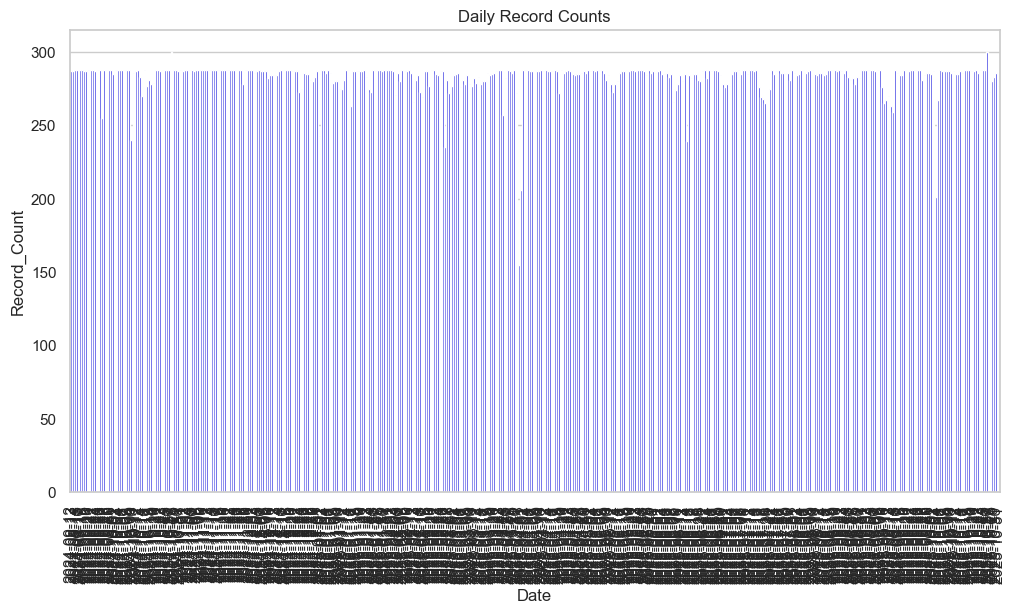

Outliers with MORE than 300 records:


,Date,Source_File


In [201]:
# Do a aggregation to daily level
df_date_counts = df_raw_daily_solar['Date'].value_counts().reset_index()
df_date_counts.columns = ['Date', 'Record_Count']
df_date_counts = df_date_counts.sort_values(by='Date')
# Plot the daily record counts
plt.figure(figsize=(12,6))
sns.barplot(data=df_date_counts, x='Date', y='Record_Count', color='blue')
plt.xticks(rotation=90)
plt.title('Daily Record Counts')
plt.show()
# print outliers where record count is less than 24
outliers = df_date_counts[df_date_counts['Record_Count'] > 300]
print("Outliers with MORE than 300 records:")
df_dups = df_raw_daily_solar[df_raw_daily_solar['Date'].isin(outliers['Date'])][['Date','Source_File']].drop_duplicates().sort_values(by='Date')
df_dups

#### Load Raw Monthly

In [202]:

all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Monthly*xls'):
    df_header = pd.read_excel(file, nrows=5, header=None)
    # get date from header
    the_date = None
    the_date_label = df_header.iat[0,0]
    # format of date is Plant_12-09-2024Chart
    result = re.search(r'(\d{2}-\d{4})', str(the_date_label))
    if result:
        date_str = result.group(1)
        the_date = datetime.datetime.strptime(date_str, '%m-%Y').date()
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df['Month'] = the_date
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    # Convert date column to date type format is dd-mm-yyyy
    #df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y').dt.date
    all_dfs.append(df)
# Combine all at once
df_raw_monthly_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
# Rename column Time to Date
df_raw_monthly_solar = df_raw_monthly_solar.rename(columns={'Time':'Date'})
# Convert Date column to date 
df_raw_monthly_solar['Date'] = pd.to_datetime(df_raw_monthly_solar['Date'], format='%d-%m-%Y').dt.date
# Set date as index
df_raw_monthly_solar.set_index('Date', inplace=True)


##### Write to CSV and Database

In [210]:
print("Writing monthly solar data to CSV...")
df_raw_monthly_solar.to_csv(f'{DATA_DIR}/processed_data/df_raw_monthly_solar.csv', index=False)
print(f"Wrote {len(df_raw_monthly_solar)} rows to CSV.")
# Write to SQLite database
print("Writing monthly solar data to SQLite database...")
row_count = df_raw_monthly_solar.to_sql('weekly_solar_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM weekly_solar_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'weekly_solar_data')

Writing monthly solar data to CSV...
Wrote 434 rows to CSV.
Writing monthly solar data to SQLite database...
Wrote 434 rows to SQLite database.
Verified 434 rows in SQLite database.
--- Schema for 'weekly_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     Date            DATE       0         
1     Number          INTEGER    0         
2     Yield(kWh)      REAL       0         
3     Earning(EUR)    REAL       0         
4     Full Load Hours(h) REAL       0         
5     Charged(kWh)    REAL       0         
6     Discharged(kWh) REAL       0         
7     Exported(kWh)   REAL       0         
8     Imported(kWh)   REAL       0         
9     Net Import(kWh) REAL       0         
10    Load(kWh)       REAL       0         
11    Month           DATE       0         
12    Source_File     TEXT       0         


__Validate Raw Monthly__

TODO

In [203]:

print("Combined Monthly DataFrame shape:", df_raw_monthly_solar.shape)  
print("DataFrame info:")
df_raw_monthly_solar.info()
print("Columns:", df_raw_monthly_solar.columns.tolist())
print("First 5 rows:")

# get min and max Date columns that will indicate range
min_date = df_raw_monthly_solar.index.min()
max_date = df_raw_monthly_solar.index.max()
no_dates = (max_date - min_date).days + 1
print("No dates in range:", no_dates)
# Date datatype check
print("Date column datatype:", df_raw_monthly_solar.index.dtype)
print(f"Date range: {min_date} to {max_date}")
#no_of_days = (max_date - min_date).days + 1
#print(f"Total number of days in range: {no_of_days}")
# Count unique dates
unique_dates = df_raw_monthly_solar.index.nunique()
print(f"Unique dates count: {unique_dates}")
if unique_dates == no_dates:
    print("No missing dates in the monthly solar data.")

Combined Monthly DataFrame shape: (434, 12)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 434 entries, 2024-10-01 to 2024-09-30
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Number              434 non-null    int64  
 1   Yield(kWh)          434 non-null    float64
 2   Earning(EUR)        434 non-null    float64
 3   Full Load Hours(h)  434 non-null    float64
 4   Charged(kWh)        434 non-null    float64
 5   Discharged(kWh)     434 non-null    float64
 6   Exported(kWh)       434 non-null    float64
 7   Imported(kWh)       434 non-null    float64
 8   Net Import(kWh)     434 non-null    float64
 9   Load(kWh)           434 non-null    float64
 10  Month               434 non-null    object 
 11  Source_File         434 non-null    object 
dtypes: float64(9), int64(1), object(2)
memory usage: 44.1+ KB
Columns: ['Number', 'Yield(kWh)', 'Earning(EUR)', 'Full Load Hours(h)', 'Ch

__Plot a few things to see how the data looks__

 Date                
 Yield(kWh)                 
 Full Load Hours(h)  
 Charged(kWh)        
 Discharged(kWh)     
 Exported(kWh)       
 Imported(kWh)       
 Net Import(kWh)     
 Load(kWh)           

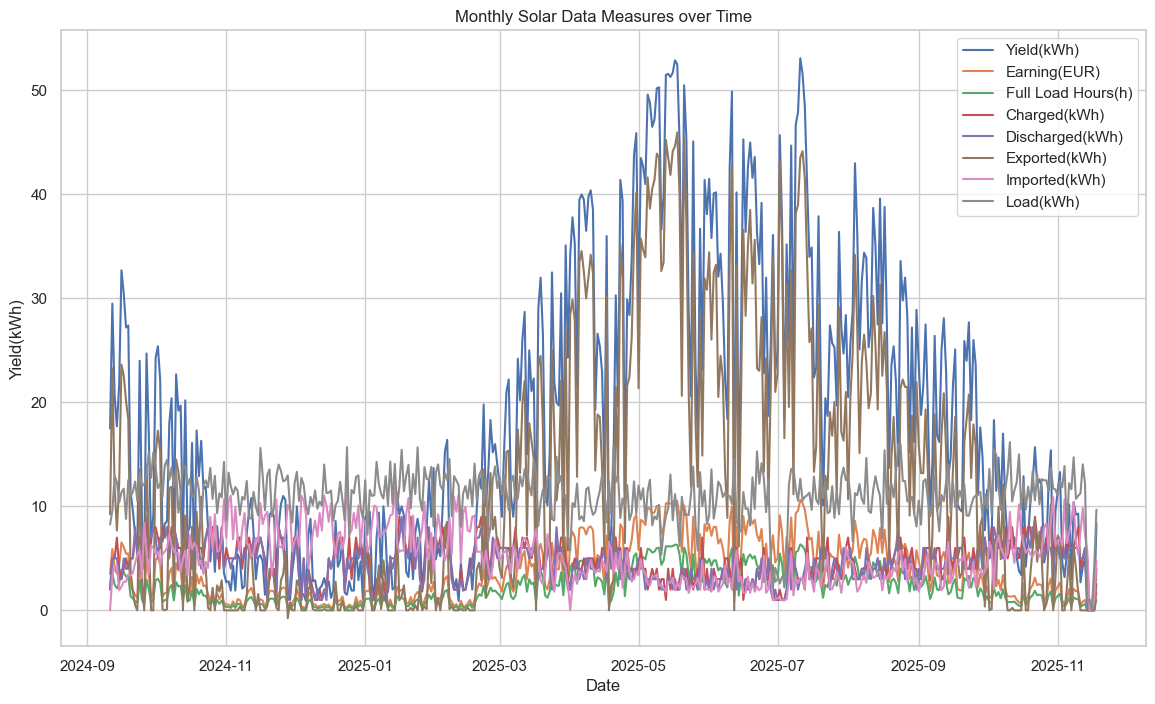

In [172]:
# plot date vs all the other measures in kWh on one plot
sns.set(style="whitegrid")
# Set title
plt.figure(figsize=(14, 8))
plt.title('Monthly Solar Data Measures over Time')
for column in df_raw_monthly_solar.columns:
    if column not in ['Date', 'Source_File', 'Month','Number','Earnings(EUR)','Net Import(kWh)']:
        sns.lineplot(data=df_raw_monthly_solar, x='Date', y=column, label=column)
plt.legend()
plt.show()

#### Load Yearly Raw Data

In [211]:

all_dfs = []
for file in glob.glob(f'{RAW_DATA_DIR}/solar/Annual*xls'):
    df = pd.read_excel(file,skiprows=28)
    # add insert date as first column
    df.insert(0, 'Date', the_date)
    # The total yield as last column
    df['Total_Yield(kWh)'] = total_yield
    # add file name column in case there are duplicates
    df['Source_File'] = os.path.basename(file)
    #print(df.head())
    all_dfs.append(df)
# Combine all at once
df_raw_annual_solar = pd.concat(all_dfs, ignore_index=True)
# remove all_dfs to free memory
del all_dfs
# Rename column Time to Date
df_raw_annual_solar = df_raw_annual_solar.rename(columns={'Time':'Month'})
# Create Date column from Month
df_raw_annual_solar['Date'] = '01-' + df_raw_annual_solar['Month']
# Convert Date column to datetime
df_raw_annual_solar['Date'] = pd.to_datetime(df_raw_annual_solar['Date'], format='%d-%m-%Y').dt.date

    

__Validate Yearly__

In [212]:
print("Combined Annual DataFrame shape:", df_raw_annual_solar.shape)  
print("DataFrame info:")
df_raw_annual_solar.info()
print("Columns:", df_raw_annual_solar.columns.tolist())
df_raw_annual_solar.head(16)

Combined Annual DataFrame shape: (15, 14)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                15 non-null     object 
 1   Number              15 non-null     int64  
 2   Month               15 non-null     object 
 3   Yield(kWh)          15 non-null     float64
 4   Earning(EUR)        15 non-null     float64
 5   Full Load Hours(h)  15 non-null     float64
 6   Charged(kWh)        15 non-null     float64
 7   Discharged(kWh)     15 non-null     float64
 8   Exported(kWh)       15 non-null     float64
 9   Imported(kWh)       15 non-null     float64
 10  Net Import(kWh)     15 non-null     float64
 11  Load(kWh)           15 non-null     float64
 12  Total_Yield(kWh)    15 non-null     float64
 13  Source_File         15 non-null     object 
dtypes: float64(10), int64(1), object(3)
memory usage: 

,Date,Number,Month,Yield(kWh),Earning(EUR),Full Load Hours(h),Charged(kWh),Discharged(kWh),Exported(kWh),Imported(kWh),Net Import(kWh),Load(kWh),Total_Yield(kWh),Source_File
0,2025-01-01,1,01-2025,210.0,42.00,25.12,144.0,133.0,60.48,234.24,173.76,372.76,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
1,2025-02-01,2,02-2025,237.0,47.40,28.35,150.0,140.0,91.56,195.48,103.92,330.92,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
2,2025-03-01,3,03-2025,602.0,120.40,72.01,175.0,161.0,388.20,156.48,-231.72,356.28,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
3,2025-04-01,4,04-2025,896.0,179.20,107.18,139.0,131.0,687.36,116.04,-571.32,316.68,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
4,2025-05-01,5,05-2025,1280.0,256.00,153.11,101.0,92.0,1053.60,86.76,-966.84,304.16,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
5,2025-06-01,6,06-2025,994.5,198.90,118.96,100.0,93.0,755.64,78.60,-677.04,310.46,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
6,2025-07-01,7,07-2025,981.7,196.34,117.43,116.0,112.0,752.52,89.88,-662.64,315.06,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
7,2025-08-01,8,08-2025,878.0,175.60,105.02,144.0,132.0,624.60,113.40,-511.20,354.80,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
8,2025-09-01,9,09-2025,571.5,114.30,68.36,157.0,150.0,355.08,112.92,-242.16,322.34,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls
9,2025-10-01,10,10-2025,292.1,58.42,34.94,203.0,192.0,107.52,197.76,90.24,371.34,8.4,Annual+Power+Station+Chart_19-11-2025 (1).xls


__Plot Data__

Plot to see what it looks like. Should see a bell like curve because of the seasonality



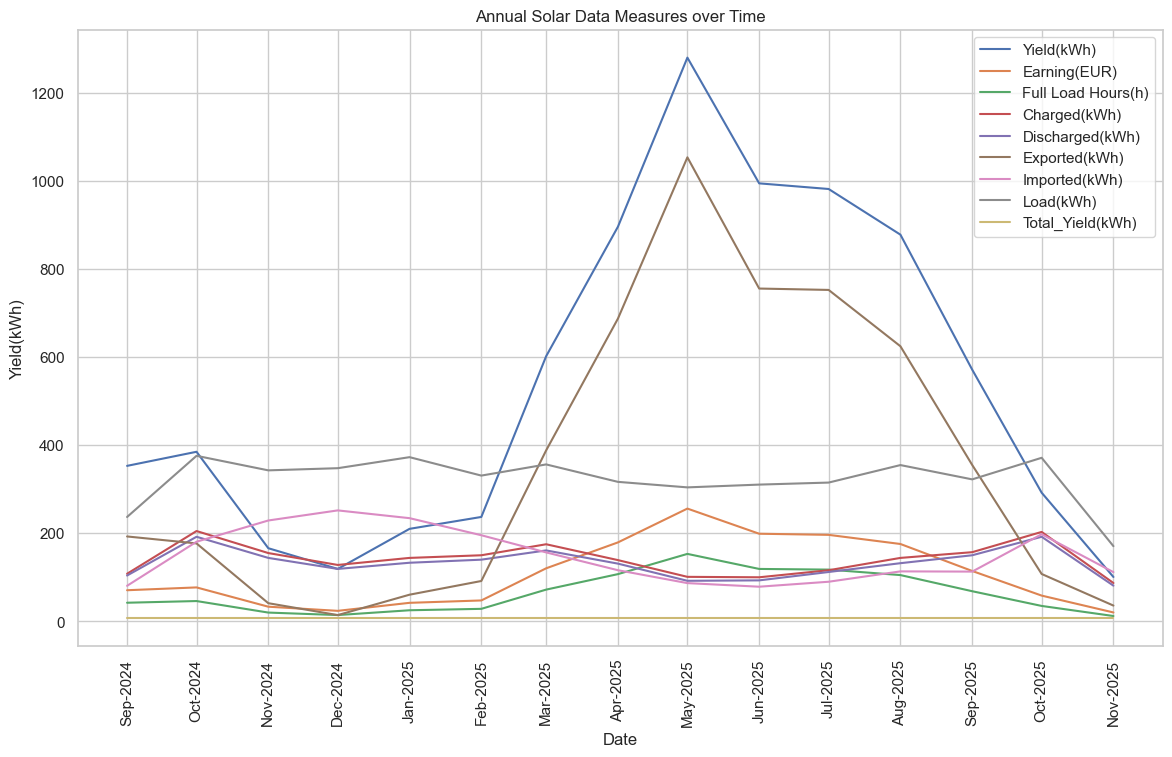

In [213]:
# plot date vs all the other measures in kWh on one plot
sns.set(style="whitegrid")
# Set title
plt.figure(figsize=(14, 8))
plt.title('Annual Solar Data Measures over Time')
for column in df_raw_annual_solar.columns:
    if column not in ['Date', 'Source_File', 'Month','Number','Earnings(EUR)','Net Import(kWh)']:
        sns.lineplot(data=df_raw_annual_solar, x='Date', y=column, label=column)
ax = plt.gca() # Get current axis

# 1. Set the Locator: Tell matplotlib to put a tick at every month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# 2. Set the Formatter: Tell matplotlib how to write the text (e.g., Jan-2023)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# 3. Rotate ticks
plt.tick_params(axis='x', rotation=90)
plt.legend()
plt.show()

##### Write to CSV and Database

In [214]:
print("Writing yearly solar data to CSV...")
df_raw_annual_solar.to_csv(f'{DATA_DIR}/processed_data/df_raw_yearly_solar.csv', index=False)
print(f"Wrote {len(df_raw_annual_solar)} rows to CSV.")
# Write to SQLite database
print("Writing yearly solar data to SQLite database...")
row_count = df_raw_annual_solar.to_sql('monthly_solar_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM monthly_solar_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'monthly_solar_data')

Writing yearly solar data to CSV...
Wrote 15 rows to CSV.
Writing yearly solar data to SQLite database...
Wrote 15 rows to SQLite database.
Verified 15 rows in SQLite database.
--- Schema for 'monthly_solar_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     index           INTEGER    0         
1     Date            DATE       0         
2     Number          INTEGER    0         
3     Month           TEXT       0         
4     Yield(kWh)      REAL       0         
5     Earning(EUR)    REAL       0         
6     Full Load Hours(h) REAL       0         
7     Charged(kWh)    REAL       0         
8     Discharged(kWh) REAL       0         
9     Exported(kWh)   REAL       0         
10    Imported(kWh)   REAL       0         
11    Net Import(kWh) REAL       0         
12    Load(kWh)       REAL       0         
13    Total_Yield(kWh) REAL       0         
14    Source_File     TEXT       0         


In [215]:
# List all tables in the database
sys_cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = sys_cur.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])

Tables in the database:
daily_solar_data
df_raw_monthly_solar
df_raw_yearly_solar
weekly_solar_data
monthly_solar_data


### Load ESB Microgeneration Data

In [217]:
# load into pandas dataframe csv file
df_raw_esb_microgen = pd.read_csv(f'{RAW_DATA_DIR}/esb/BGE_Export_HDF_18_11_2025.csv')
# change Date column to date
df_raw_esb_microgen['Date'] = pd.to_datetime(df_raw_esb_microgen['Date']).dt.date 
# change Date to index
df_raw_esb_microgen.set_index('Date', inplace=True)

In [222]:
print("ESB Microgen DataFrame shape:", df_raw_esb_microgen.shape)
print("DataFrame info:")
df_raw_esb_microgen.info()
print("Columns:", df_raw_esb_microgen.columns.tolist())
print("First 5 rows:")
print(df_raw_esb_microgen.head())


ESB Microgen DataFrame shape: (435, 3)
DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 435 entries, 2024-09-05 to 2025-11-13
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MPRN                 435 non-null    int64  
 1   Export Volume (kWh)  435 non-null    float64
 2   Export Type          435 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 13.6+ KB
Columns: ['MPRN', 'Export Volume (kWh)', 'Export Type']
First 5 rows:
                  MPRN  Export Volume (kWh) Export Type
Date                                                   
2024-09-05  9999999999                  0.0     Metered
2024-09-06  9999999999                  0.0     Metered
2024-09-07  9999999999                  0.0     Metered
2024-09-08  9999999999                  0.0     Metered
2024-09-09  9999999999                  0.0     Metered


#### Write to CSV and Database

In [229]:
print("Writing daily ESB microgen data to CSV...")
df_raw_esb_microgen.to_csv(f'{DATA_DIR}/processed_data/df_raw_daily_esb_microgen.csv', index=False)
print(f"Wrote {len(df_raw_esb_microgen)} rows to CSV.")
# Write to SQLite database
print("Writing daily ESB microgen data to SQLite database...")
row_count = df_raw_esb_microgen.to_sql('daily_esb_microgen_data', con, if_exists='replace', index=True)
print(f"Wrote {row_count} rows to SQLite database.")
# Now do a short query to verify
test_query = "SELECT COUNT(*) FROM daily_esb_microgen_data;"
sys_cur.execute(test_query)
result = sys_cur.fetchone()
print(f"Verified {result[0]} rows in SQLite database.")
sqlite3_table_schema(con, 'daily_esb_microgen_data')

Writing daily ESB microgen data to CSV...
Wrote 435 rows to CSV.
Writing daily ESB microgen data to SQLite database...
Wrote 435 rows to SQLite database.
Verified 435 rows in SQLite database.
--- Schema for 'daily_esb_microgen_data' ---
ID    Name            Type       NotNull   
---------------------------------------------
0     Date            DATE       0         
1     MPRN            INTEGER    0         
2     Export Volume (kWh) REAL       0         
3     Export Type     TEXT       0         


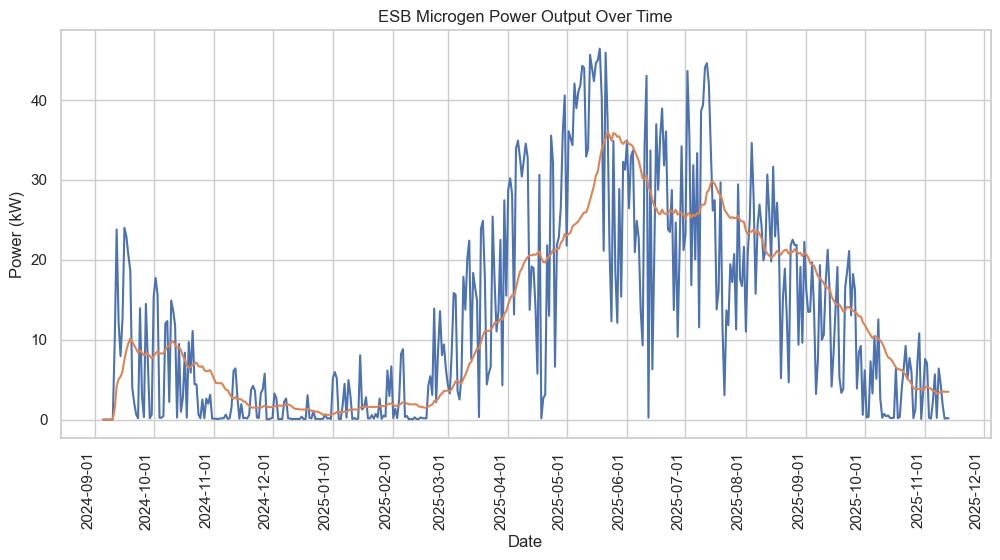

In [228]:

# Plot esb microgen data
plt.figure(figsize=(12,6))
ss = df_raw_esb_microgen['Export Volume (kWh)']
ss.plot()
# plot a smooth line
ss.rolling(window=30,min_periods=1).mean().plot()
plt.title('ESB Microgen Power Output Over Time')
plt.xlabel('Date')
# set x axis major ticks to monthly at 90 degrees
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate(rotation=90)
plt.ylabel('Power (kW)')
plt.grid(True)
plt.show()

__Analysis__

The question is , does ESB microgeneration kWH per day compare with the amount of power exported to the grid. The data from solar system (df_raw_monthly_solar) Column Exported(kWh)  and ESB microgeneration(df_raw_esb_microgen) column (Export Volume (kWh)) need to be joined on the same date grain. That is date.

In [230]:

df_esb_solar_merged = pd.merge(left=df_raw_esb_microgen['Export Volume (kWh)'].copy().reset_index('Date'),
         right=df_raw_monthly_solar['Exported(kWh)'].copy().reset_index('Date'),how='inner', on='Date')
# subtact the two columns to see difference
df_esb_solar_merged['Difference(kWh)'] = df_esb_solar_merged['Exported(kWh)'] - df_esb_solar_merged['Export Volume (kWh)']

__Plot Results__

This will compare the results of data measured by ESB and Solar System Inverter. This is to see if there are any obvious differences between the measurements. There is expected to be a slight difference because the two devices are different , and they are measureing at different point. At a visual difference there is no real measurable difference except for 1 day , which may be related to a power outage . 

__Observation__

The graph show that there is no material difference , if the outlier is removed that it shows a over reporting for ESB , or under for solar . We cannot determine which one is correct , rather we know either , or both are slighly incorrect.

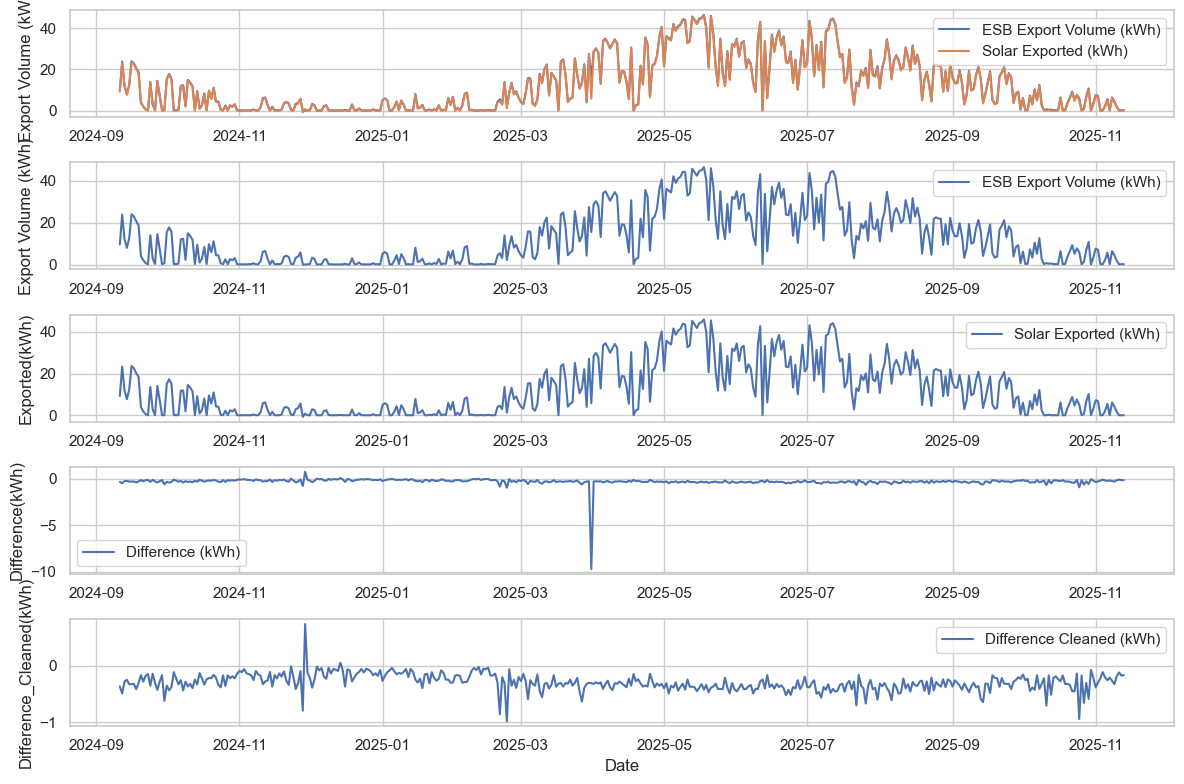

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(12, 8))

# Combined plot first
sns.lineplot(data=df_esb_solar_merged, x='Date', y='Export Volume (kWh)', label='ESB Export Volume (kWh)', ax=ax[0])
sns.lineplot(data=df_esb_solar_merged, x='Date', y='Exported(kWh)', label='Solar Exported (kWh)', ax=ax[0])
ax[0].set_xlabel('')

# Plot each separately
sns.lineplot(data=df_esb_solar_merged, x='Date', y='Export Volume (kWh)', label='ESB Export Volume (kWh)', ax=ax[1])
ax[1].set_xlabel('')

sns.lineplot(data=df_esb_solar_merged, x='Date', y='Exported(kWh)', label='Solar Exported (kWh)', ax=ax[2])
ax[2].set_xlabel('')

sns.lineplot(data=df_esb_solar_merged, x='Date', y='Difference(kWh)', label='Difference (kWh)', ax=ax[3])
ax[3].set_xlabel('')

# Replace outlier values in Difference(kWh) with NaN for better visualization
# using a lambda function to set values greater than abs(5) to NaN
# a lamba is an anonymous function in Python
df_esb_solar_merged['Difference_Cleaned(kWh)'] = df_esb_solar_merged['Difference(kWh)'].apply(lambda x: x if abs(x) < 5 else np.nan)
sns.lineplot(data=df_esb_solar_merged, x='Date', y='Difference_Cleaned(kWh)', label='Difference Cleaned (kWh)', ax=ax[4])

plt.tight_layout()
plt.show()

__Method Comparison Study__

I used the following prompt on gemini 3.0 Thinking

I am doing a project on my solar panels at home , i have two measures of the same thing. Exported KWh but from different sources , what statistical techinques can i use to analise the difference

The prompt gave me a number of options

1. The Gold Standard: Bland-Altman Plot
2. Hypothesis Testing: Paired t-Test
3. Error Metrics: MAE and RMSE



__Bland-Altman Plot__

This is the primary visual test used in science and engineering to compare two measurement techniques.

What it does: It plots the Difference between the two sources (Y-axis) against the Average of the two sources (X-axis).

Why use it: It instantly reveals if the error gets worse as generation gets higher (proportional bias) or if one meter always reads higher by a fixed amount (systematic bias).

Examing the results

- there is one outlier
- systemic bias - there is a slight bias above the meaning that one of the devices is overreading, or alternatively one of the readers is slightly higher than the other , we do not know which one is the truth
- consistency - there is strong consistency because the reading consistent along the limits of agreement

[Wiki Band Altman Plot](https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot)

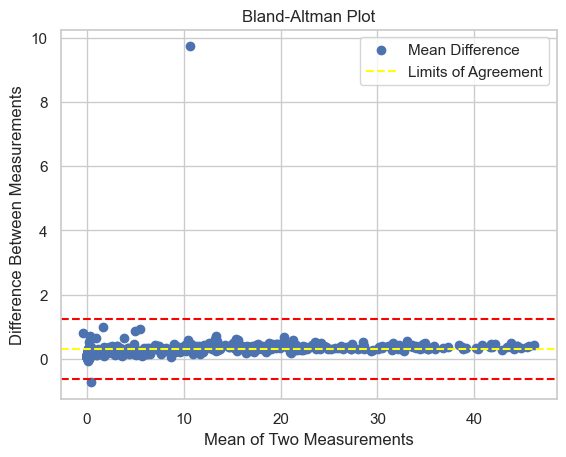

Outliers where difference is greater than 5 kWh:


,Date,Export Volume (kWh),Exported(kWh),Difference(kWh)
201,2025-03-31,15.4915,5.76,-9.7315


In [ ]:
# View Bland-Altman Plot
# asarray converts pandas series to numpy array
data1 = np.asarray(df_esb_solar_merged['Export Volume (kWh)'])
data2 = np.asarray(df_esb_solar_merged['Exported(kWh)'])
# calculate the mean between the two measurements and the difference
mean = np.mean([data1, data2], axis=0)
diff = data1 - data2
plt.scatter(mean, diff)
plt.axhline(np.mean(diff), color='yellow', linestyle='--')
plt.axhline(np.mean(diff) + 1.96*np.std(diff), color='red', linestyle='--')
plt.axhline(np.mean(diff) - 1.96*np.std(diff), color='red', linestyle='--')
plt.xlabel('Mean of Two Measurements')
plt.ylabel('Difference Between Measurements')
plt.title('Bland-Altman Plot')
# The yellow line represents the mean difference
# The red lines represent the limits of agreement (mean difference ± 1.96 standard deviations)
plt.legend(['Mean Difference', 'Limits of Agreement'])
plt.show()
# print out the outlier

print("Outliers where difference is greater than 5 kWh:")
outliers = df_esb_solar_merged[abs(df_esb_solar_merged['Difference(kWh)']) > 5]
outliers

__Hypothesis Test ( Paired t-test )__

Paired t-test: Use this if your differences are normally distributed (bell curve).

In [ ]:
from scipy import stats
# remove the outliers for the t-test
df_esb_solar_merged_no_outliers = df_esb_solar_merged[abs(df_esb_solar_merged['Difference(kWh)']) <= 5]
data1 = np.asarray(df_esb_solar_merged_no_outliers['Export Volume (kWh)'])
data2 = np.asarray(df_esb_solar_merged_no_outliers['Exported(kWh)'])
# perform paired t-test
t_stat, p_value = stats.ttest_rel(data1, data2)
print(f"\n--- Statistical Test (Paired t-test) ---")
print(f"P-value: {p_value:.5f}")
if p_value < 0.05:
    print("Result: Statistically Significant Difference (The sources are NOT the same)")
else:
    print("Result: No significant difference found")


--- Statistical Test (Paired t-test) ---
P-value: 0.00000
Result: Statistically Significant Difference (The sources are NOT the same)


You can know if the paired t-test is valid by checking three specific assumptions.

For solar data, the most critical one is Normality of the Differences. Many people mistakenly think the solar generation itself needs to be a Bell curve (which it never is—it's zero at night and high in summer). This is wrong. Only the difference between your Inverter and Utility meter needs to look like a Bell curve.

The 3 Assumptions Checklist
Continuous Data: Verified. (Kilowatt-hours are continuous numbers).

Independence of Pairs: Verified. (The error on Monday doesn't "cause" the error on Tuesday; each day is a separate event).

Normality of Differences: Must be tested. The Inverter - Utility values should form a Bell curve (Normal Distribution).

How to Interpret the Results
If the Histogram is a Bell Curve (and p-value > 0.05): Your differences are random "noise." The Paired t-test is the correct tool.

If the Histogram is skewed or flat (and p-value < 0.05): Your differences are not random. This often happens in solar if the inverter has a "cutoff" issue or if that outlier you found earlier is skewing the data.

Solution: Use the Wilcoxon Signed-Rank Test. It does the same job as the t-test but doesn't care about Bell curves.

Python code: stats.wilcoxon(df['Inverter'], df['Meter'])

Important Note on Your Outlier

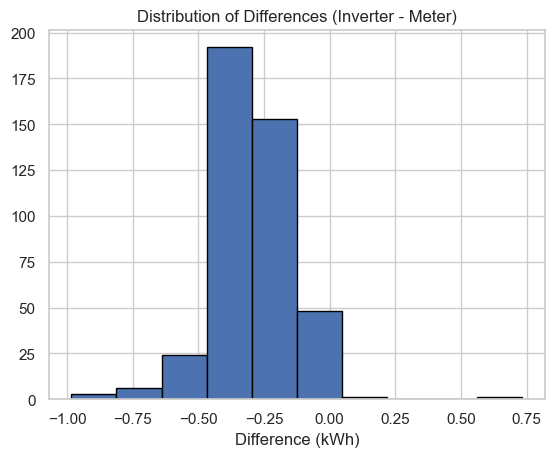

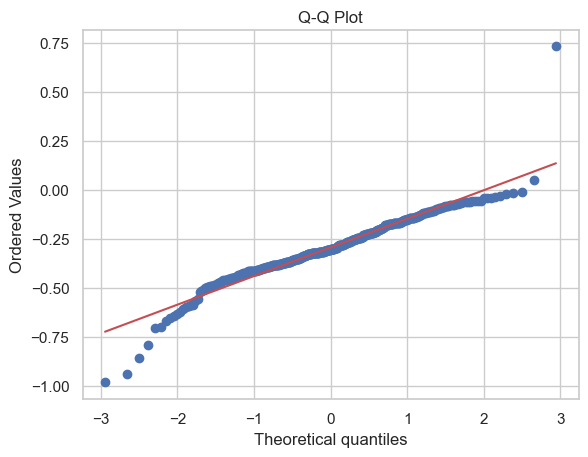

Shapiro-Wilk P-Value: 0.00000
FAILED: Data is NOT Normal. Use 'Wilcoxon Signed-Rank Test' instead.


In [236]:
import matplotlib.pyplot as plt
import scipy.stats as stats
df = df_esb_solar_merged_no_outliers.copy()
df = df.rename(columns={'Export Volume (kWh)': 'Meter', 'Exported(kWh)': 'Inverter'})
# 1. Calculate the Difference
df['Diff'] = df['Inverter'] - df['Meter']

# 2. Visual Check: Histogram
# It should look like a Bell Curve centered roughly around 0 (or your bias)
plt.hist(df['Diff'], bins=10, edgecolor='black')
plt.title('Distribution of Differences (Inverter - Meter)')
plt.xlabel('Difference (kWh)')
plt.show()

# 3. Visual Check: Q-Q Plot
# The dots should roughly follow the red line
stats.probplot(df['Diff'], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

# 4. Mathematical Check: Shapiro-Wilk Test
# This gives you a p-value.
stat, p_value = stats.shapiro(df['Diff'])

print(f"Shapiro-Wilk P-Value: {p_value:.5f}")

if p_value > 0.05:
    print("PASSED: Data is Normal. You CAN use the Paired t-test.")
else:
    print("FAILED: Data is NOT Normal. Use 'Wilcoxon Signed-Rank Test' instead.")

In [237]:
stats.wilcoxon(df['Inverter'], df['Meter'])

WilcoxonResult(statistic=np.float64(433.0), pvalue=np.float64(1.4993676371925262e-70))

In [238]:
# 2. Run the Wilcoxon Signed-Rank Test
# We use 'two-sided' to check if they are simply different (not specifically higher/lower)
statistic, p_value = stats.wilcoxon(df['Inverter'], df['Meter'], alternative='two-sided')

print("--- Wilcoxon Signed-Rank Test Results ---")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value:.5f}")

# 3. Interpretation Logic
print("\n--- Conclusion ---")
if p_value < 0.05:
    print("Result: SIGNIFICANT DIFFERENCE")
    print("There is a statistically significant difference between the Inverter and Utility meter.")
    
    # Check who is higher by looking at the median difference
    median_diff = (df['Inverter'] - df['Meter']).median()
    if median_diff > 0:
        print(f"Direction: The Inverter reads higher (Median diff: {median_diff:.3f} kWh)")
    else:
        print(f"Direction: The Utility Meter reads higher (Median diff: {median_diff:.3f} kWh)")

else:
    print("Result: NO SIGNIFICANT DIFFERENCE")
    print("The differences are likely just random noise. The devices measure effectively the same.")

--- Wilcoxon Signed-Rank Test Results ---
Statistic: 433.0
P-value: 0.00000

--- Conclusion ---
Result: SIGNIFICANT DIFFERENCE
There is a statistically significant difference between the Inverter and Utility meter.
Direction: The Utility Meter reads higher (Median diff: -0.305 kWh)


Plot of wilcox 

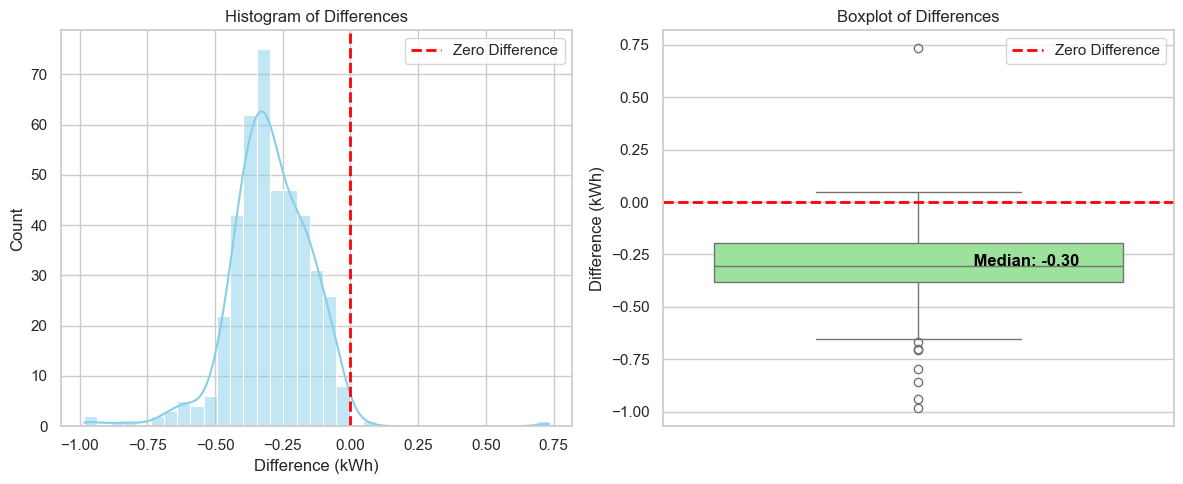

In [ ]:
# 2. Create the Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot A: Histogram (Distribution Check) ---
sns.histplot(df['Diff'], kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Difference')
axes[0].set_title('Histogram of Differences')
axes[0].set_xlabel('Difference (kWh)')
axes[0].legend()

# --- Plot B: Boxplot (The Wilcoxon Companion) ---
sns.boxplot(y=df['Diff'], ax=axes[1], color='lightgreen')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Difference')
axes[1].set_title('Boxplot of Differences')
axes[1].set_ylabel('Difference (kWh)')
axes[1].legend()

# Add a note about the median
median_val = df['Diff'].median()
axes[1].text(0.1, median_val, f' Median: {median_val:.2f}', 
             color='black', weight='bold', ha='left')

plt.tight_layout()
plt.show()

Detected Systematic Bias: -0.3047 kWh


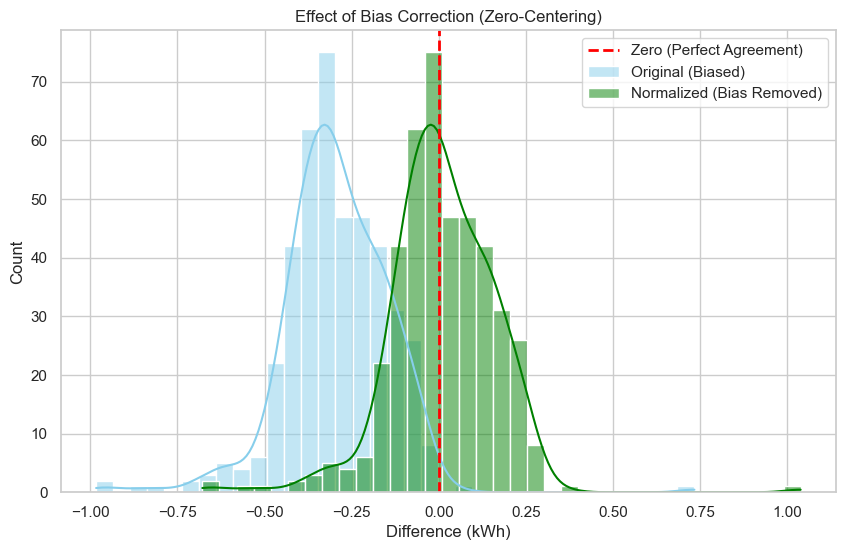

New Median after correction: 0.0000 kWh (Should be 0.0)


In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your dataframe and 'Diff' is the column plotted above
# 1. Calculate the Systematic Bias (using Median to be robust against outliers)
bias = df['Diff'].median()

print(f"Detected Systematic Bias: {bias:.4f} kWh")

# 2. Create the "Normalized" Data (Centralized on Zero)
# We subtract the bias from the difference
df['Diff_Normalized'] = df['Diff'] - bias

# --- PLOTTING ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Original (with Bias)
sns.histplot(df['Diff'], color='skyblue', alpha=0.5, label='Original (Biased)', kde=True)

# Plot Normalized (Centered on Zero)
sns.histplot(df['Diff_Normalized'], color='green', alpha=0.5, label='Normalized (Bias Removed)', kde=True)

# Add the Zero line
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero (Perfect Agreement)')

plt.title('Effect of Bias Correction (Zero-Centering)')
plt.xlabel('Difference (kWh)')
plt.legend()
plt.show()

# --- CHECK NEW METRICS ---
new_median = df['Diff_Normalized'].median()
print(f"New Median after correction: {new_median:.4f} kWh (Should be 0.0)")

In [ ]:
# --- METHOD A: Cohen's d (For Paired t-test) ---
# Mean of difference / Std Dev of difference
cohens_d = np.mean(diff) / np.std(diff, ddof=1)

# --- METHOD B: Rank-Biserial Correlation (For Wilcoxon) ---
# We perform the Wilcoxon test to get the rank sums
# exact=True is preferred for small datasets (<25), False for larger
w_stat, _ = stats.wilcoxon(df['Inverter'], df['Meter'])

# Calculate total ranks (Formula: N * (N + 1) / 2)
n = len(diff)
total_rank_sum = n * (n + 1) / 2

# In scipy, w_stat is the minimum of the two sums (positive or negative)
# So we can reverse-engineer the correlation (r)
# r = 1 - (2 * w_stat) / total_rank_sum
r_biserial = 1 - (2 * w_stat) / total_rank_sum

print("--- Effect Size Results ---")

print(f"\n1. Cohen's d (If using t-test): {cohens_d:.3f}")
# Interpretation Logic for Cohen's d
if abs(cohens_d) < 0.2: print("   -> Negligible Effect")
elif abs(cohens_d) < 0.5: print("   -> Small Effect")
elif abs(cohens_d) < 0.8: print("   -> Medium Effect")
else: print("   -> Large Effect (The difference is very noticeable)")

print(f"\n2. Rank-Biserial r (If using Wilcoxon): {r_biserial:.3f}")
# Interpretation Logic for r
if abs(r_biserial) < 0.1: print("   -> Negligible Effect")
elif abs(r_biserial) < 0.3: print("   -> Small Effect")
elif abs(r_biserial) < 0.5: print("   -> Medium Effect")
else: print("   -> Large Effect")

print("\n------------------------------------------------")
print("Note: If the number is POSITIVE, the Inverter is higher.")
print("Note: If the number is NEGATIVE, the Meter is higher.")

--- Effect Size Results ---

1. Cohen's d (If using t-test): 0.659
   -> Medium Effect

2. Rank-Biserial r (If using Wilcoxon): 0.991
   -> Large Effect

------------------------------------------------
Note: If the number is POSITIVE, the Inverter is higher.
Note: If the number is NEGATIVE, the Meter is higher.


__ Dublin Aireport Weather __

The Dublin Airport weather is the closest weather station. 

[Dublin Airport Weither](https://cli.fusio.net/cli/climate_data/webdata/hly532.csv)


Header 

date:  -  Date and Time (utc)
rain:  -  Precipitation Amount (mm)	  
temp:  -  Air Temperature (C)	
wetb:  -  Wet Bulb Temperature (C)
dewpt: -  Dew Point Temperature (C)             
rhum:  -  Relative Humidity (%)
vappr: -  Vapour Pressure (hPa)	 
msl:   -  Mean Sea Level Pressure (hPa)
wdsp:  -  Mean Wind Speed (knot)
wddir: -  Predominant Wind Direction (degree)
ww:    -  Synop code for Present Weather
w:     -  Synop code for Past Weather
sun:   -  Sunshine duration (hours)
vis:   -  Visibility (m)
clht:  -  Cloud height (100's of ft) - 999 if none 
clamt: -  Cloud amount
ind:   -  Indicator

In [ ]:
df_weather_dublin = pd.read_csv(f'{RAW_DATA_DIR}/weather/hly532.csv', skiprows=23)
df_weather_dublin['new_date_time'] = pd.to_datetime(df_weather_dublin['date'], format='%d-%b-%Y %H:%M')
df_weather_dublin['new_date'] = df_weather_dublin['new_date_time'].dt.date
# Only interested in dates between 2024-09-10 and 2025-10-31
df_weather_dublin = df_weather_dublin[(df_weather_dublin['new_date'] >= pd.to_datetime('2024-09-10').date()) & (df_weather_dublin['new_date'] <= pd.to_datetime('2025-10-31').date())]  


# show first 5 rows
df_dates=df_weather_dublin['new_date'].value_counts()
df_weather_dublin

C:\Users\cw171001\AppData\Local\Temp\ipykernel_44976\4127421478.py:1: DtypeWarning: Columns (8,9,14,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_weather_dublin = pd.read_csv(f'{RAW_DATA_DIR}/weather/hly532.csv', skiprows=23)


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.4,wddir,ww,w,sun,vis,clht,clamt,new_date_time,new_date
698568,10-sep-2024 00:00,0,0.0,0,14.1,0,12.6,11.3,13.4,83,...,2,250,2,52,0.0,20000,15,7,2024-09-10 00:00:00,2024-09-10
698569,10-sep-2024 01:00,0,0.0,0,14.1,0,12.4,10.9,13.0,81,...,2,250,2,11,0.0,20000,14,7,2024-09-10 01:00:00,2024-09-10
698570,10-sep-2024 02:00,2,0.0,0,14.0,0,12.6,11.3,13.5,84,...,2,250,50,22,0.0,20000,13,7,2024-09-10 02:00:00,2024-09-10
698571,10-sep-2024 03:00,0,0.0,0,13.8,0,12.7,11.8,13.8,87,...,2,250,2,52,0.0,20000,10,7,2024-09-10 03:00:00,2024-09-10
698572,10-sep-2024 04:00,0,0.0,0,13.7,0,12.4,11.2,13.4,85,...,2,250,2,11,0.0,20000,15,7,2024-09-10 04:00:00,2024-09-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708571,31-oct-2025 19:00,0,0.0,0,11.2,0,9.4,7.5,10.3,78,...,2,160,2,11,0.0,35000,130,6,2025-10-31 19:00:00,2025-10-31
708572,31-oct-2025 20:00,0,0.0,0,11.2,0,9.6,8.0,10.7,80,...,2,150,2,11,0.0,35000,90,6,2025-10-31 20:00:00,2025-10-31
708573,31-oct-2025 21:00,0,0.5,0,11.2,0,10.3,9.4,11.8,89,...,2,150,60,62,0.0,8000,27,7,2025-10-31 21:00:00,2025-10-31
708574,31-oct-2025 22:00,0,1.1,0,10.8,0,9.6,8.4,11.0,85,...,2,160,21,62,0.0,20000,48,8,2025-10-31 22:00:00,2025-10-31


https://cli.fusio.net/cli/climate_data/webdata/hly532.csv

To find "solar brightness" for weather in Ireland using Python, we technically need to look for Solar Irradiance.In weather data, this is measured in Watts per square meter ($W/m^2$). The most common metric is GHI (Global Horizontal Irradiance), which represents the total power of the sun hitting a horizontal surface (like a flat solar panel or the ground).1Here are the two best ways to get this data for free in Python:Open-Meteo (Best for Forecasts): Free, requires no API key, and is very easy to use for current/future weather.PVGIS via pvlib (Best for Solar Planning): Uses European Commission data, excellent for calculating potential solar energy generation based on historical averages.Option 1: Get Live & Forecast Solar Data (Open-Meteo)This is the simplest method. It uses the Open-Meteo API to get the GHI for any location in Ireland (defined by latitude and longitude).Prerequisites:You will need the requests and pandas libraries.

In [ ]:
import requests
import pandas as pd

def get_solar_brightness(lat, lon):
    # Open-Meteo API endpoint for solar forecast
    url = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters: shortwave_radiation is effectively GHI (Global Horizontal Irradiance)
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": ["shortwave_radiation", "direct_radiation", "diffuse_radiation", "cloud_cover"],
        "timezone": "Europe/Dublin"
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Process hourly data
        hourly = data['hourly']
        df = pd.DataFrame({
            'Time': pd.to_datetime(hourly['time']),
            'GHI (W/m²)': hourly['shortwave_radiation'],
            'Cloud Cover (%)': hourly['cloud_cover']
        })
        
        return df
    
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

# Example: Coordinates for Dublin, Ireland
latitude = 53.3498
longitude = -6.2603

df = get_solar_brightness(latitude, longitude)

if df is not None:
    # Filter for daylight hours only (GHI > 0) to see "brightness"
    daylight_data = df[df['GHI (W/m²)'] > 0].head(12)
    
    print(f"--- Solar Brightness Forecast for Dublin ---")
    print(daylight_data.to_string(index=False))
    
    # Simple Interpretation
    current_ghi = daylight_data.iloc[0]['GHI (W/m²)']
    print("\n--- Interpretation ---")
    if current_ghi > 800:
        print("Status: Very Sunny/Bright ☀️")
    elif current_ghi > 300:
        print("Status: Moderate/Partly Cloudy ⛅")
    else:
        print("Status: Low Light/Cloudy ☁️")

--- Solar Brightness Forecast for Dublin ---
               Time  GHI (W/m²)  Cloud Cover (%)
2025-11-20 09:00:00        33.0                9
2025-11-20 10:00:00       131.0                5
2025-11-20 11:00:00       199.0               13
2025-11-20 12:00:00       266.0                0
2025-11-20 13:00:00       280.0                0
2025-11-20 14:00:00       241.0                0
2025-11-20 15:00:00       166.0                0
2025-11-20 16:00:00        68.0                0
2025-11-20 17:00:00         2.0                0
2025-11-21 09:00:00        24.0               98
2025-11-21 10:00:00       108.0               12
2025-11-21 11:00:00       208.0               97

--- Interpretation ---
Status: Low Light/Cloudy ☁️


Option 2: Get Historical/Planning Data (PVGIS)
If you are planning a solar panel installation and need to know the average brightness for a specific month in Ireland, the PVGIS database (provided by the EU Science Hub) is the gold standard. We access this using the pvlib library.

Prerequisites:

[Photovoltaic Geographical Information System](https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis_en)
[pvlib](https://pvlib-python.readthedocs.io/en/stable/)

In [ ]:
import pvlib
import pandas as pd

def get_average_solar_data(lat, lon):
    print("Fetching data from PVGIS (European Commission)...")
    
    try:
        # fetch_pvgis_tmy returns a tuple, we need the first element (the dataframe)
        data, metadata = pvlib.iotools.get_pvgis_tmy(
            latitude=lat, 
            longitude=lon,
            map_variables=True,
            startyear=2022,
            endyear=2023
        )
        
        # Resample to daily averages to see seasonal brightness
        daily_avg = data['ghi'].resample('D').mean()
        
        # Map day numbers
        #daily_avg.index = daily_avg.index.strftime('%B')
        print(daily_avg.head())
        
        return daily_avg

    except Exception as e:
        print(f"Error: {e}")
        return None

# Example: Coordinates for Cork, Ireland
# Example: Coordinates for Bettystown, Ireland
latitude = 53.7014
longitude = -6.2461
monthly_data = get_average_solar_data(latitude, longitude)

if monthly_data is not None:
    print("\n--- Average Solar Irradiance (GHI) in Bettystown (W/m²) ---")
    print(monthly_data)
monthly_data = get_average_solar_data(latitude, longitude)
monthly_data

Fetching data from PVGIS (European Commission)...
Error: startyear, endyear: Incorrect time period. The calculation period for this app should be at least 10 years.
Fetching data from PVGIS (European Commission)...
Error: startyear, endyear: Incorrect time period. The calculation period for this app should be at least 10 years.


## Clear Sky Data

The clear sky data is the theoritcal output of the sun if there were no clouds.  The base code was from Gemini. 
Prompt: How do i find out the clear sky solar radiation using python.  The objective is to see if the efficiency of the solar panels can be determine using a emperical method. 

In [14]:
import pandas as pd
import pvlib
from pvlib.location import Location

# 1. Define Location (Bettystown, Ireland)
lat, lon = 53.7014, -6.2461
tz = 'Europe/Dublin'
site = Location(lat, lon, tz=tz, altitude=10, name='Bettystown')

# 2. Define the time period (e.g., Tomorrow)
# We create a frequency of 10 minutes to get a smooth curve
times = pd.date_range(start='2024-11-20 00:00', end='2025-11-20 23:59', freq='10min', tz=tz)

# 3. Calculate Clear Sky Data
# This uses the 'Ineichen' model which is standard for clear sky
# It automatically estimates atmospheric clarity (turbidity) based on your location
cs = site.get_clearsky(times, model='ineichen')

# 4. Calculate Total Daily Energy (Insolation)
# GHI is Global Horizontal Irradiance (Watts/m2)
# We sum the watts and divide by 6 (since data is every 10 mins) and 1000 (to get kWh)
total_daily_energy = cs['ghi'].sum() / 6 / 1000

print(f"--- Theoretical Clear Sky Limit for Bettystown ---")
print(f"Date: {times[0].date()}")
print(f"Max Potential Energy: {total_daily_energy:.2f} kWh/m²")
print(f"Peak Brightness (Noon): {cs['ghi'].max():.0f} W/m²")


--- Theoretical Clear Sky Limit for Bettystown ---
Date: 2024-11-20
Max Potential Energy: 1474.20 kWh/m²
Peak Brightness (Noon): 832 W/m²


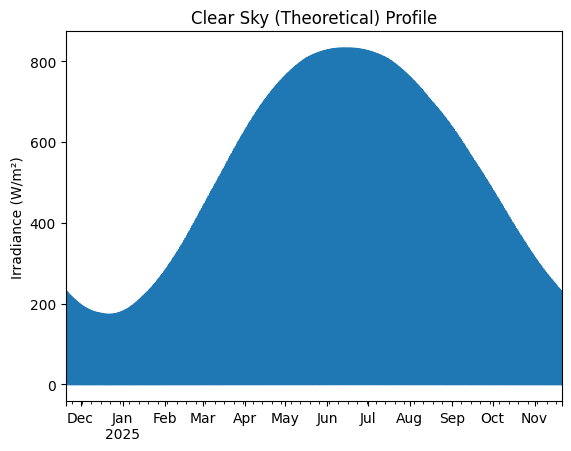

In [15]:

# Optional: Plot it to see the perfect curve
try:
    import matplotlib.pyplot as plt
    cs['ghi'].plot()
    plt.ylabel('Irradiance (W/m²)')
    plt.title('Clear Sky (Theoretical) Profile')
    plt.show()
except ImportError:
    print("Install matplotlib to see the graph.")

In [ ]:
# plot 1 day of solar data
plt.figure(figsize=(12,6))
cs['ghi'].plot()
plt.ylabel('Irradiance (W/m²)')
plt.title('Clear Sky (Theoretical) Profile')
plt.show()

__Cleanup__

In [179]:
# Close the database connection
sys_cur.close()
con.close()